In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
import time
import rk_solver_cpp
from scipy.integrate import solve_ivp
from tqdm import tqdm


In [10]:
def setup_gas(T, pp, ratio):
    gas = ct.Solution('mechanism_files/ch4_53species.yaml')
    gas.TP = T, ct.one_atm*pp
    gas.set_equivalence_ratio(ratio, 'CH4', 'O2:1.0, N2:3.76')
    return gas, pp 

def combustion_ode(gas, pp):
    def f(t, Y):
        T = Y[0]
        YY = Y[1:]
        gas.TPY = T, ct.one_atm*pp, YY
        species_rates = gas.net_production_rates*gas.molecular_weights/gas.density
        species_h = gas.partial_molar_enthalpies/gas.molecular_weights
        temp_rate = -np.sum(species_rates*species_h/gas.cp_mass)
        return np.concatenate((np.array([temp_rate]), species_rates), axis=0)
    return f

In [14]:
def solve_ivp_cpp(f, t_span, y0, ts, rtol, atol):
    rk23 = rk_solver_cpp.RK23(f, t_span[0], y0, t_span[1], rtol, atol)
    ys_cpp = []
    start_time = time.time()
    time_cpp = 0
    for t in tqdm(ts, desc="C++ RK23"):
        rk23.integrate(t)
        time_cpp += time.time() - start_time
        ys_cpp.append(np.array(rk23.get_y()))
    return ys_cpp, time_cpp


In [16]:
T = 1400
pp = 40
ratio = 1.0

rtol = 1e-6
atol = 1e-8

gas, pp = setup_gas(T, pp, ratio)

f = combustion_ode(gas, pp)
y0 = np.hstack([[gas.T], gas.Y])
t_span = (0.0, 2e-4)
npoints = 100
ts = np.linspace(t_span[0], t_span[1], npoints + 1)

ys_cpp, time_cpp = solve_ivp_cpp(f, t_span, y0, ts, rtol, atol)



C++ RK23: 100%|██████████| 101/101 [01:06<00:00,  1.53it/s]


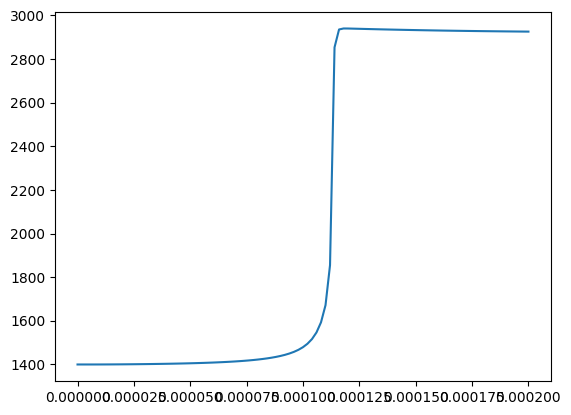

In [1]:
def benchmark_combustion(gas, pp, t_span, npoints):
    f = combustion_ode(gas, pp)
    y0 = np.hstack([[gas.T], gas.Y])
    ts = np.linspace(t_span[0], t_span[1], npoints + 1)

    # C++ RK23
    rk23 = rk_solver_cpp.RK23(f, t_span[0], y0, t_span[1], rtol=1e-6, atol=1e-8)
    start_time = time.time()
    ys_cpp = []
    try:
        for t in tqdm(ts, desc="C++ RK23"):
            rk23.integrate(t)
            ys_cpp.append(np.array(rk23.get_y()))
        time_cpp = time.time() - start_time
        cpp_success = True
    except Exception as e:
        print(f"C++ RK23 failed: {str(e)}")
        time_cpp = None
        cpp_success = False

    # SciPy RK45
    start_time = time.time()
    sol_scipy = solve_ivp(f, t_span, y0, method='RK23', t_eval=ts, rtol=1e-6, atol=1e-8)
    time_scipy = time.time() - start_time

    # Print results
    print(f"\nResults for Combustion Integration:")
    if cpp_success:
        print(f"C++ RK23 time: {time_cpp:.6f} s")
    print(f"SciPy RK23 time: {time_scipy:.6f} s")

    # Plotting
    plt.figure(figsize=(12, 6))
    if cpp_success:
        plt.plot(ts, [y[0] for y in ys_cpp], label='C++ RK23', linestyle='--')
    plt.plot(sol_scipy.t, sol_scipy.y[0], label='SciPy RK23', linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.title('Combustion Integration - Temperature vs Time')
    plt.legend()
    plt.savefig('combustion_integration_comparison.png')
    plt.close()

    # Plot species mass fractions
    species_to_plot = ['CH4', 'O2', 'CO2', 'H2O']
    species_indices = [gas.species_index(s) for s in species_to_plot]
    
    plt.figure(figsize=(12, 8))
    for i, species in enumerate(species_to_plot):
        if cpp_success:
            plt.plot(ts, [y[species_indices[i]+1] for y in ys_cpp], label=f'{species} (C++ RK23)', linestyle='--')
        plt.plot(sol_scipy.t, sol_scipy.y[species_indices[i]+1], label=f'{species} (SciPy RK23)', linestyle='-')
    plt.xlabel('Time (s)')
    plt.ylabel('Mass Fraction')
    plt.title('Combustion Integration - Species Mass Fractions')
    plt.legend()
    plt.yscale('log')
    plt.savefig('combustion_integration_species_comparison.png')
    plt.close()



In [ ]:
if __name__ == "__main__":
    gas, pp = setup_gas()
    t_span = (0.0, 8.0)
    npoints = 100
    benchmark_combustion(gas, pp, t_span, npoints)